## Import libs

In [1]:

import os
import time
import numpy as np

import cv2

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import pickle

from scipy.ndimage.measurements import label

from moviepy.editor import VideoFileClip
from IPython.display import HTML


## Get HOG features

In [2]:

orient = 9
pix_per_cell = 8
cell_per_block = 2

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, 
            orientations=orient, 
            pixels_per_cell=(pix_per_cell, pix_per_cell), 
            cells_per_block=(cell_per_block, cell_per_block), 
            visualise=vis, 
            feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, 
            orientations=orient, 
            pixels_per_cell=(pix_per_cell, pix_per_cell), 
            cells_per_block=(cell_per_block, cell_per_block), 
            visualise=vis, 
            feature_vector=feature_vec)
        return features


## Example images

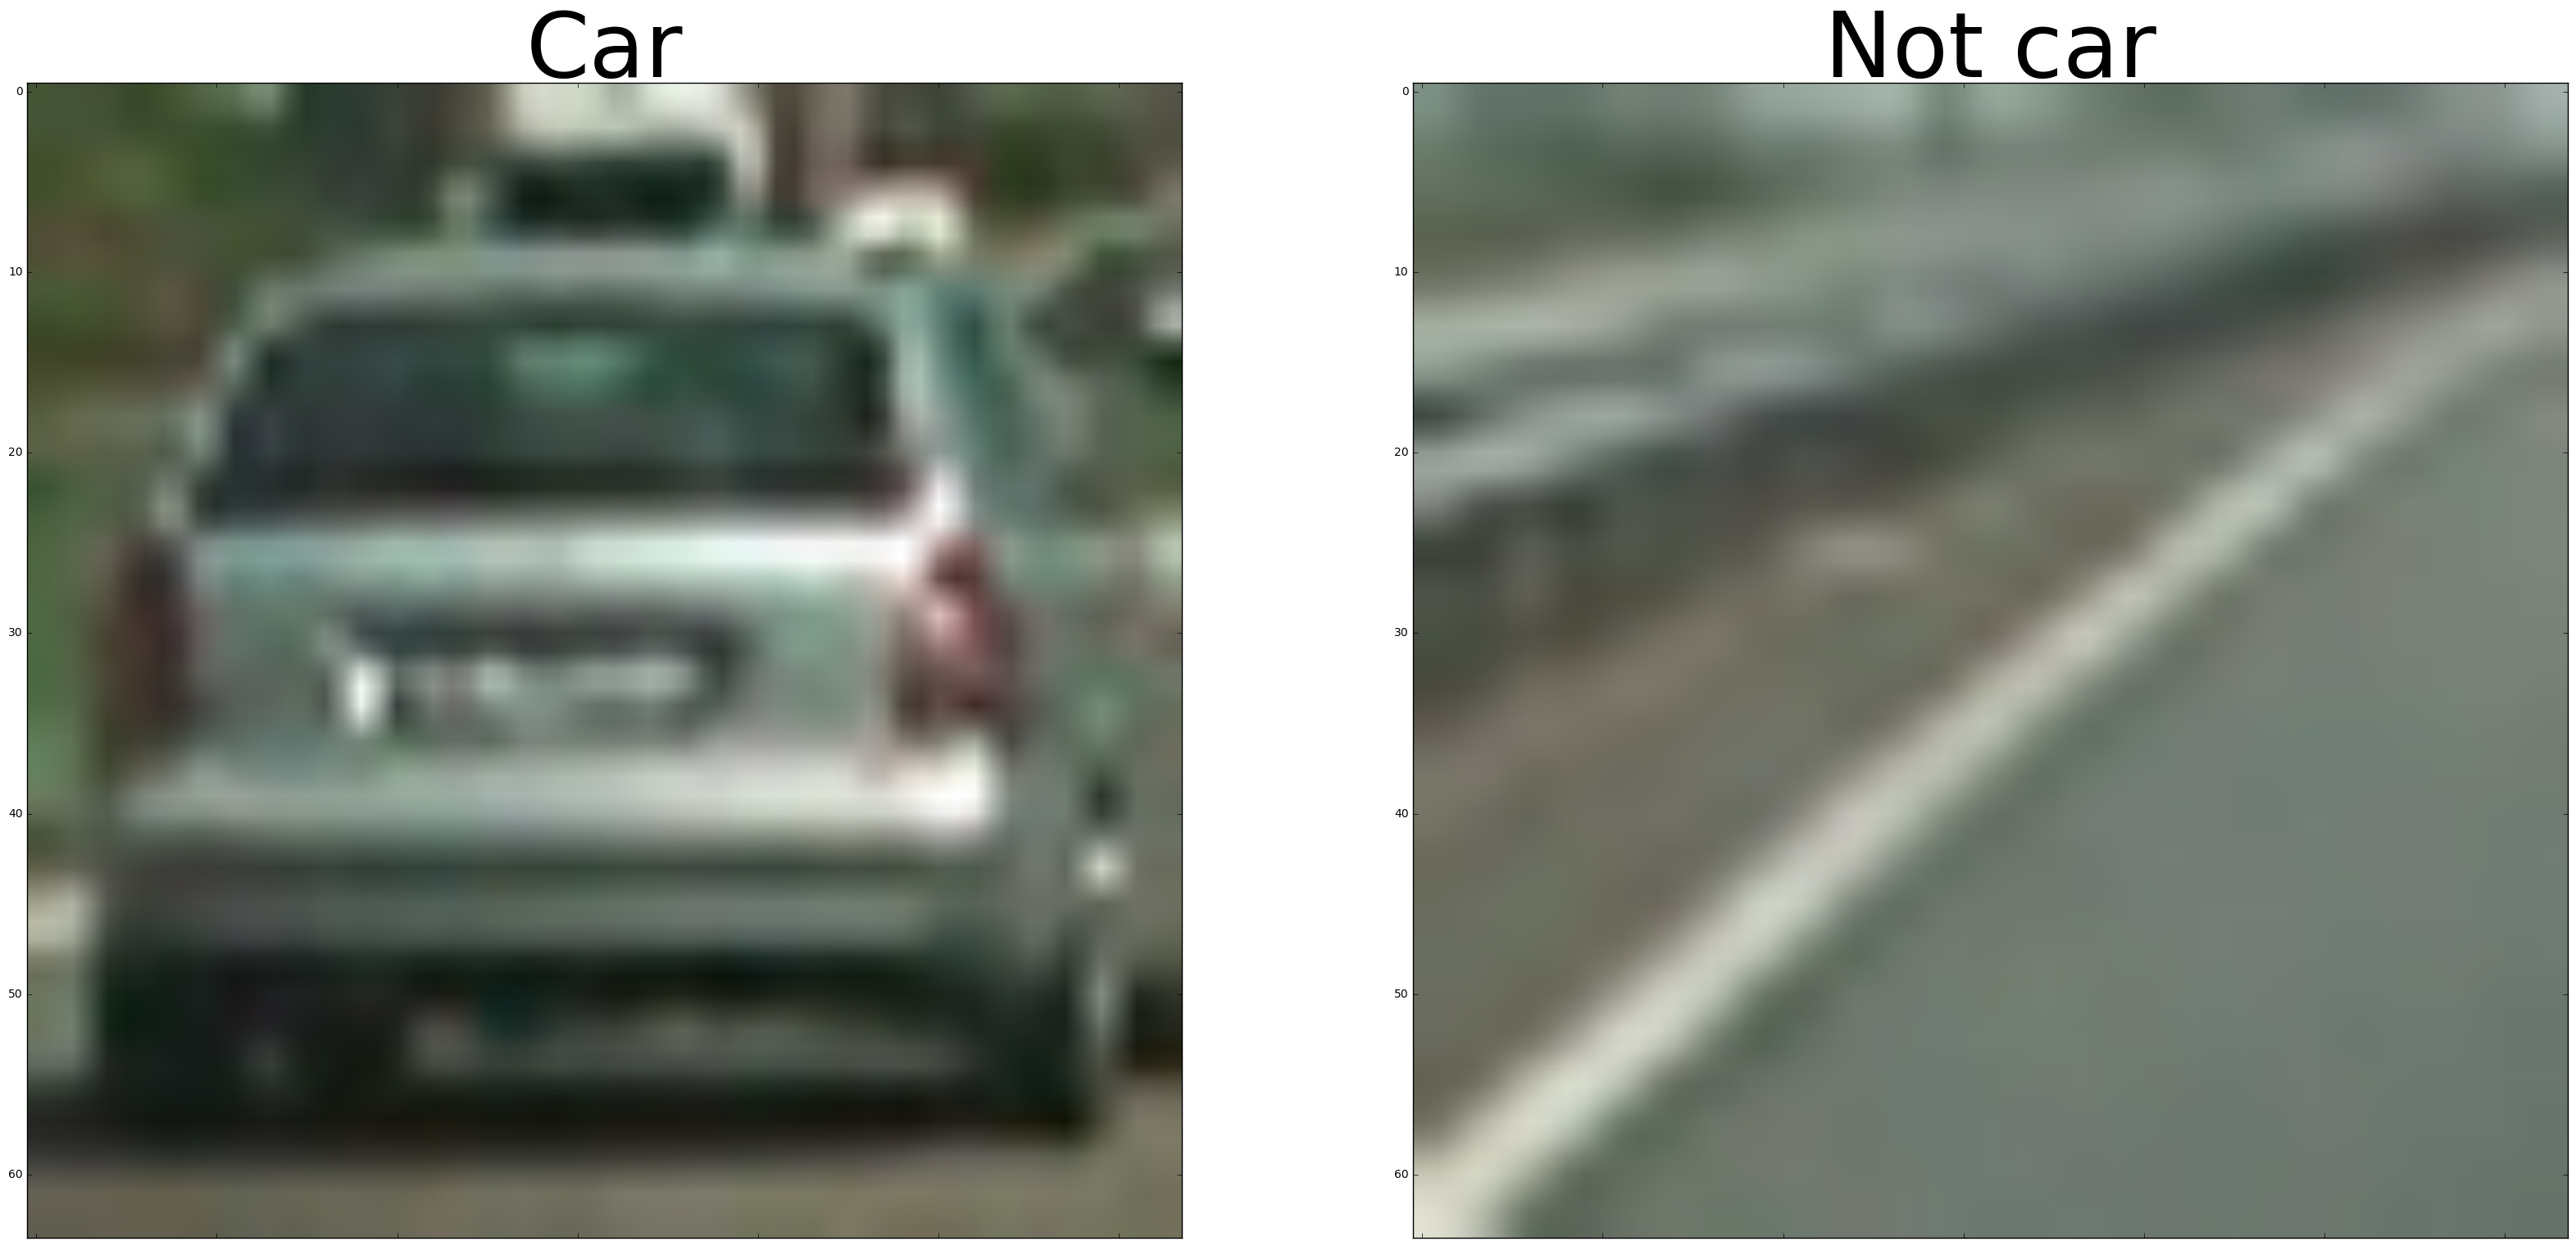

In [3]:

folder = "./test_images/"
files = ["car_test1.png", "not_car_test1.png"]
titles = ["Car", "Not car"]
f, axarr = plt.subplots(1, 2, figsize=(40, 30))
for i in range(len(files)):
    img = mpimg.imread(folder + files[i])
    axarr[i].imshow(img)
    axarr[i].set_title(titles[i], fontsize=80)
    plt.setp(axarr[i].get_xticklabels(), visible=False)
    plt.setp(axarr[i].get_xticklabels(), visible=False)
plt.show()
    

## HOG images

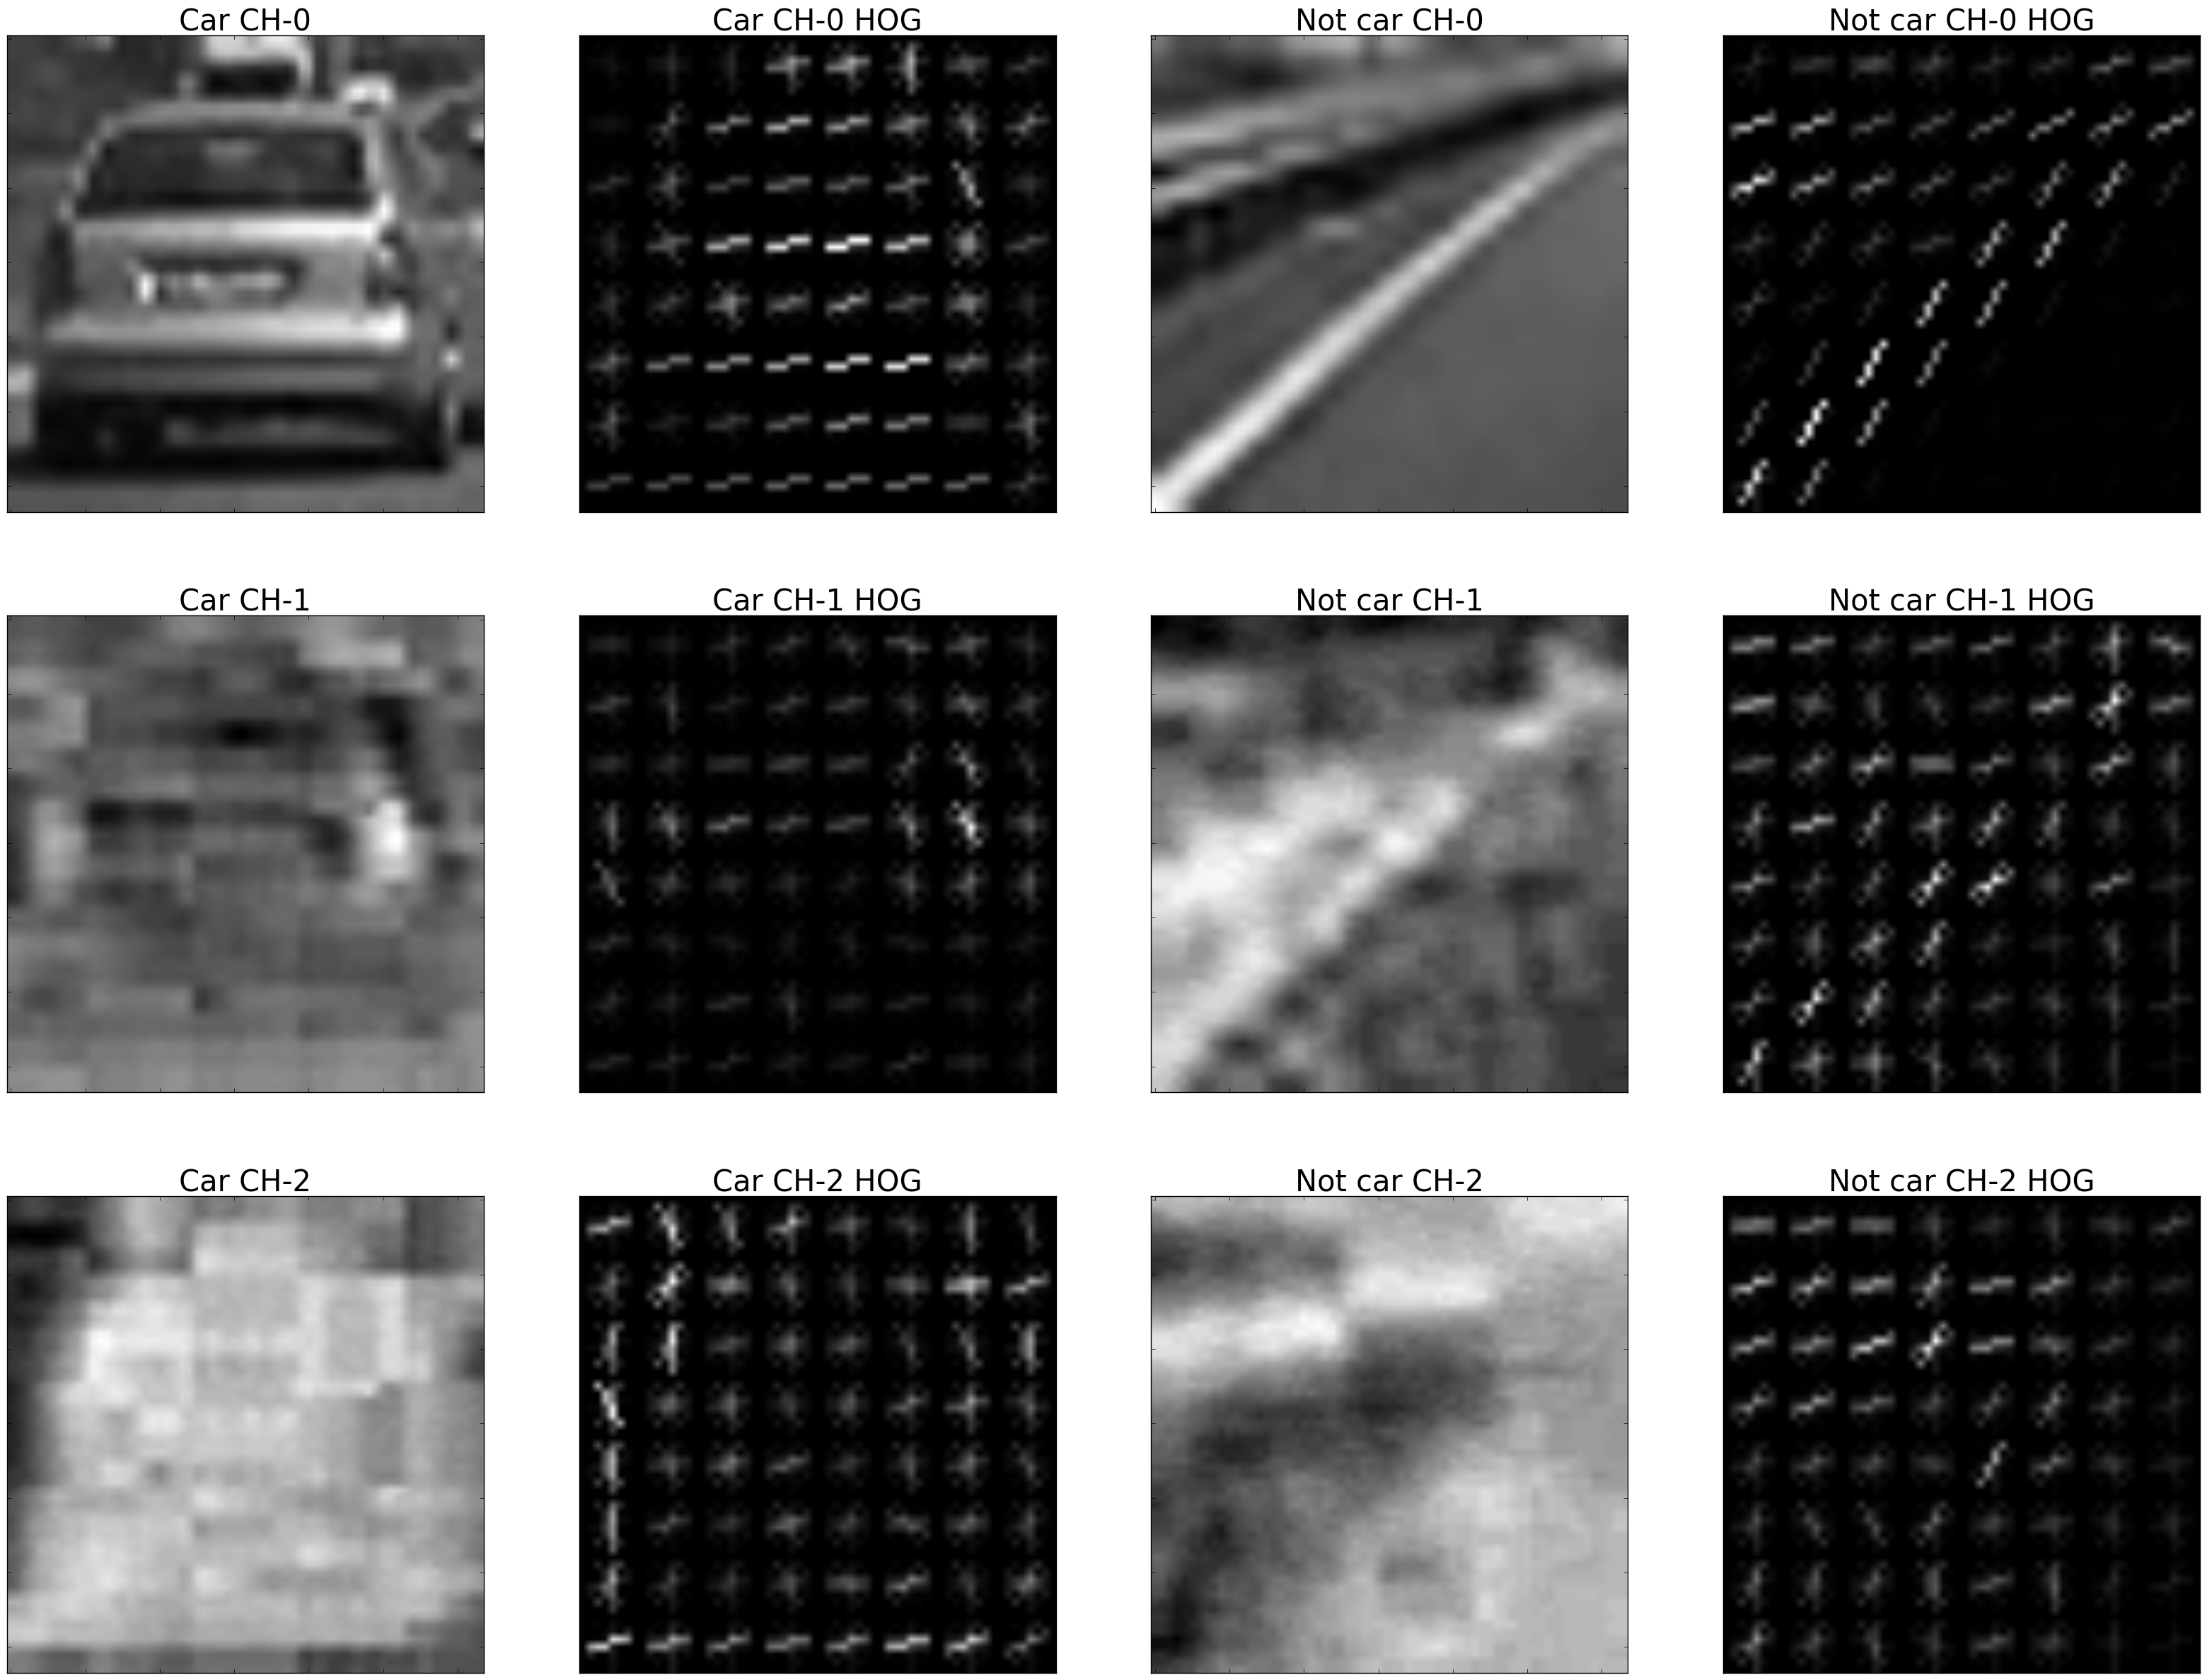

In [4]:

f, axarr = plt.subplots(3, 4, figsize=(40, 30))

for fi in range(len(files)):
    raw_img = mpimg.imread(folder + files[fi])
    img = cv2.cvtColor(raw_img, cv2.COLOR_RGB2YCrCb)
    
    for ci in range(3):
        channel = img[:,:,ci]
        hog_feature, hog_image = get_hog_features(channel, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False);
        axarr[ci][2*fi+0].imshow(channel, cmap='gray')
        axarr[ci][2*fi+0].set_title(titles[fi] + " CH-{0}".format(ci), fontsize=30)
        axarr[ci][2*fi+1].imshow(hog_image, cmap='gray')
        axarr[ci][2*fi+1].set_title(titles[fi] + " CH-{0} HOG".format(ci), fontsize=30)
        plt.setp(axarr[ci][2*fi+0].get_xticklabels(), visible=False)
        plt.setp(axarr[ci][2*fi+0].get_yticklabels(), visible=False)
        plt.setp(axarr[ci][2*fi+1].get_xticklabels(), visible=False)
        plt.setp(axarr[ci][2*fi+1].get_yticklabels(), visible=False)
plt.show()   


## Read and save image data in .p

In [5]:

car_folder = "./test_images/vehicles/vehicles" # read image under this folder recursivey
not_car_folder = "./test_images/non-vehicles/non-vehicles" # read image under this folder recursivey

test_path = ""

def read_and_save_images(folder, pickle_file):
    images = []
    for subdir, dirs, files in tqdm(os.walk(folder)):
        for file in files:
            path = subdir + '/' + file
            _, file_extension = os.path.splitext(file)
            if file_extension != '.png':
                continue
            img = mpimg.imread(path)
            images.append(img)
    with open(pickle_file, 'wb') as p:
        pickle.dump(
            {
                'images': images,
            },
            p, pickle.HIGHEST_PROTOCOL)

read_and_save_images(car_folder, 'car_images.p')
read_and_save_images(not_car_folder, 'not_car_images.p')


6it [00:18,  4.35s/it]
3it [00:24,  8.07s/it]


## Load .p and compose training/test data

In [6]:

car_images = []
not_car_images = []

with open('car_images.p', 'rb') as p:
    pickle_data = pickle.load(p)
    car_images = pickle_data['images']

with open('not_car_images.p', 'rb') as p:
    pickle_data = pickle.load(p)
    not_car_images = pickle_data['images']

print('num car images: ', len(car_images))
print('num not car images: ', len(not_car_images))


num car images:  8792
num not car images:  8968


## Extract features

In [7]:

def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel()
    return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features


In [8]:

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    features = []
    for image in tqdm(imgs):
        img_features =  extract_features_single(image, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat);
        features.append(img_features)
    return features

def extract_features_single(image, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    img_features = []
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=(0,1))
        img_features.append(hist_features)
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        img_features.append(hog_features)
    return np.concatenate(img_features)


## Train SVC

In [9]:

car_features = extract_features(car_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(not_car_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state);

svc = LinearSVC()
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


100%|███████████████████████████████████████| 8968/8968 [00:20<00:00, 440.62it/s]


10.1 seconds to train SVC...
Test Accuracy of SVC =  0.9851


## Slide windows

In [10]:

y_start_stop = [400, None]
xy_overlap = (0.5, 0.5)

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step)
    window_list = []
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            window_list.append(((startx, starty), (endx, endy)))
    return window_list

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy


## Search Windows

In [11]:

def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    on_windows = []
    for window in windows:
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        features = extract_features_single(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        prediction = clf.predict(test_features)
        if prediction == 1:
            on_windows.append(window)
    return on_windows


## Find cars : main pipeline

In [12]:

xy_windows = [(64, 64), (86, 86), (108, 108), (128, 128)]

def find_cars(img, clf, scaler, x_start_stop=[None, None], y_start_stop=[None, None], 
              xy_windows=[(64, 64)], xy_overlap=(0.5, 0.5), color_space='RGB', 
              spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256), orient=9, 
              pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_feat=True, hist_feat=True, hog_feat=True):
    img = img.astype(np.float32)/255
    window_list = []
    for xy_window in xy_windows:
        window_list_single = slide_window(img, y_start_stop=y_start_stop, xy_window=xy_window, xy_overlap=xy_overlap)
        window_list.extend(window_list_single)
    on_window = search_windows(img, window_list, clf, scaler, color_space=color_space,
                               spatial_size=spatial_size, hist_bins=hist_bins, 
                               hist_range=hist_range, orient=orient, 
                               pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,                               
                               hog_channel=hog_channel, spatial_feat=spatial_feat, 
                               hist_feat=hist_feat, hog_feat=hog_feat)
    return on_window


## Test finding pipeline

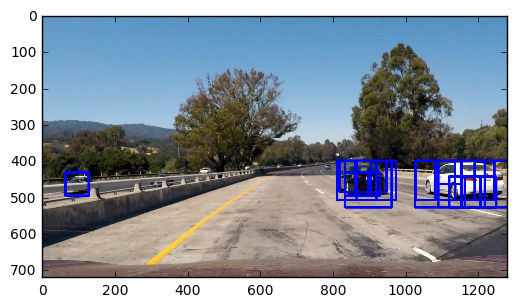

In [13]:

image = mpimg.imread('./test_images/test1.jpg')
windows = find_cars(image, clf=svc, scaler=X_scaler, y_start_stop=y_start_stop,
                   xy_windows=xy_windows, xy_overlap=xy_overlap, color_space=color_space,
                   spatial_size=spatial_size, hist_bins=hist_bins, orient=orient,
                   pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, 
                   spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
draw_img = draw_boxes(image, windows)
plt.imshow(draw_img)
plt.show()


## Heat map

In [19]:

heat_thres = 1

def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

def stack_heat(heat1, heat2):
    heatmap = np.array([x + y for x, y in zip(heat1, heat2)])
    return heatmap

def apply_threshold(heatmap, heat_thres):
    heatmap[heatmap <= heat_thres] = 0
    return heatmap

def labeled_windows(img, labels):
    windows = []
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        windows.append(bbox)
    return windows


## Test heat map

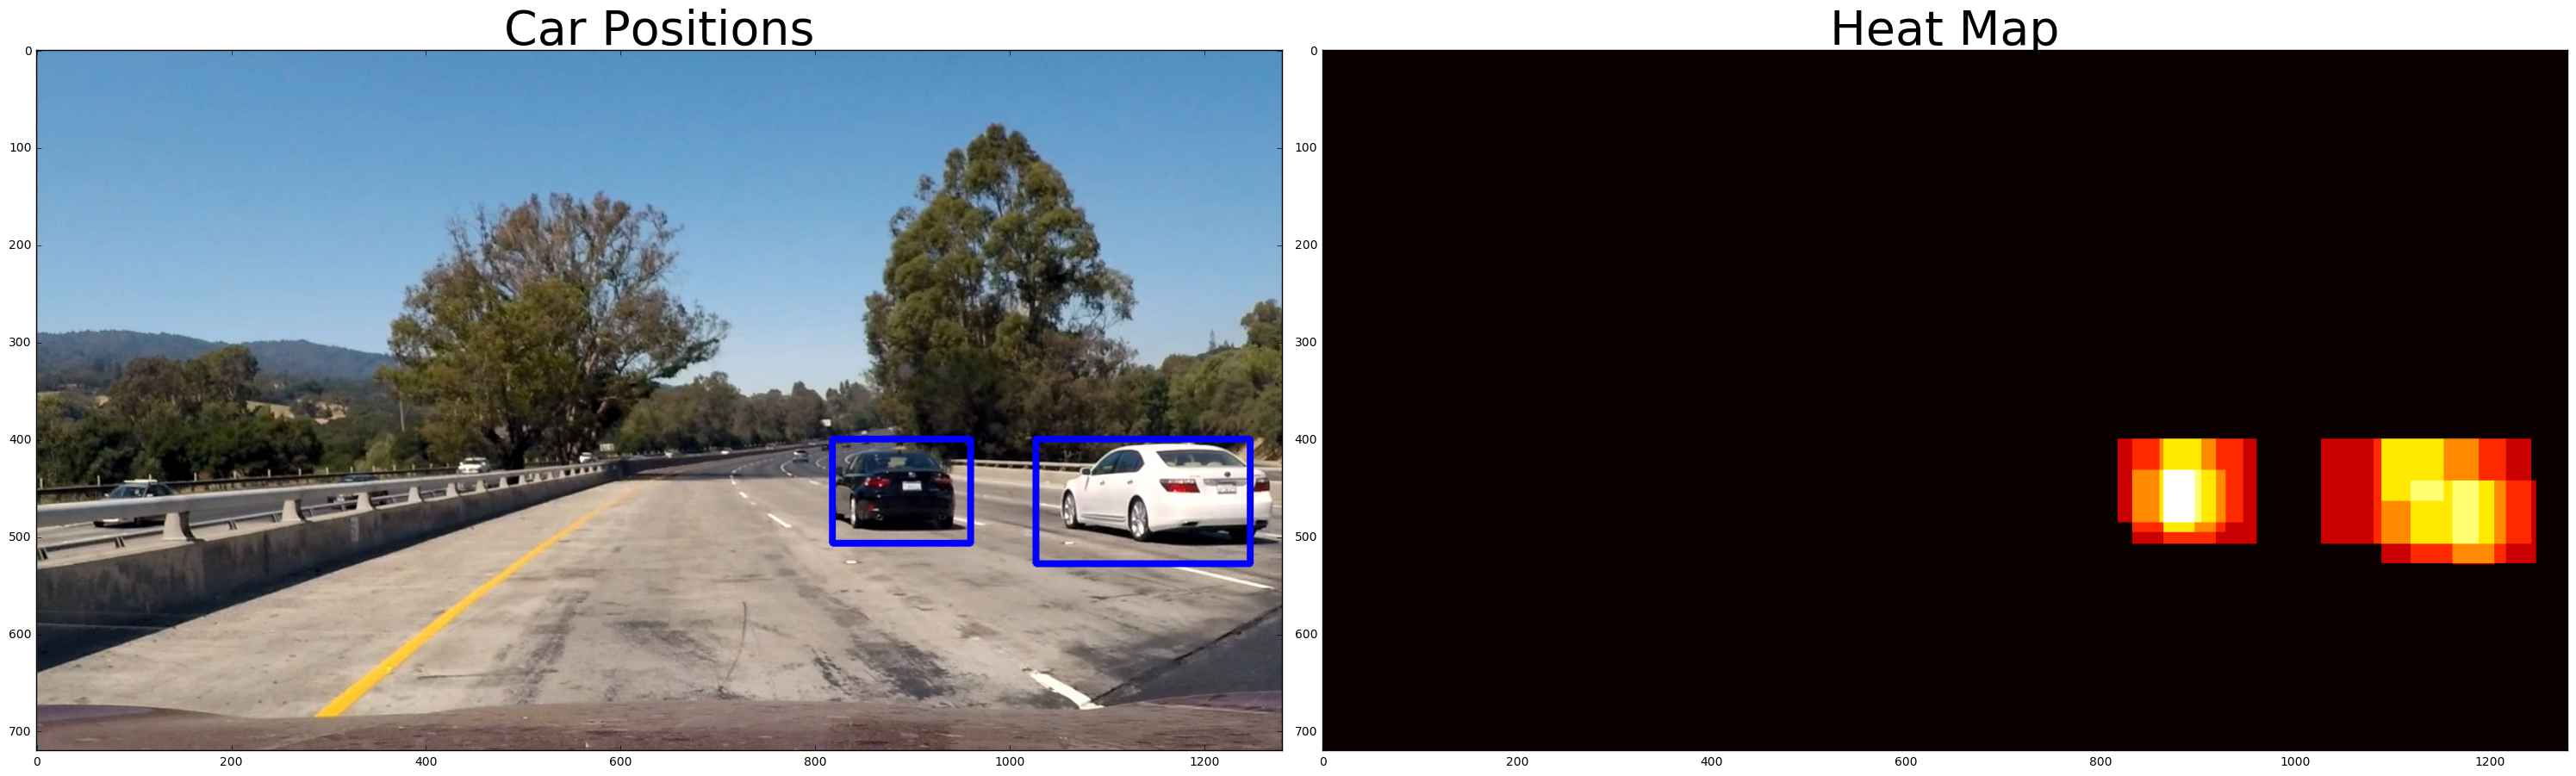

In [15]:

image = mpimg.imread('./test_images/test1.jpg')
windows = find_cars(image, clf=svc, scaler=X_scaler, y_start_stop=y_start_stop,
                   xy_windows=xy_windows, xy_overlap=xy_overlap, color_space=color_space,
                   spatial_size=spatial_size, hist_bins=hist_bins, orient=orient,
                   pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, 
                   spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

heat = np.zeros_like(image[:,:,0]).astype(np.float)
heat = add_heat(heat, windows)
heat = apply_threshold(heat, heat_thres=heat_thres)
heatmap = np.clip(heat, 0, 255)
labels = label(heatmap)
windows = labeled_windows(img, labels)
draw_img = draw_boxes(image, windows)

fig = plt.figure(figsize=(30, 20))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions', fontsize=40)
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map', fontsize=40)
fig.tight_layout()
plt.show()


## Process image (False positive detection)

In [22]:

use_prev_windows = True
prev_windows = []
heat_thres_cont = 2

frame_skip_max = 3
frame_skip_cnt = 0

def process_image(image):
    global use_prev_windows, prev_windows, heat_thres_cont, frame_skip_max, frame_skip_cnt
    windows = []
    if frame_skip_cnt == 0:
        windows = find_cars(image, clf=svc, scaler=X_scaler, y_start_stop=y_start_stop,
                       xy_windows=xy_windows, xy_overlap=xy_overlap, color_space=color_space,
                       spatial_size=spatial_size, hist_bins=hist_bins, orient=orient,
                       pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, 
                       spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
        frame_heat = np.zeros_like(image[:,:,0]).astype(np.float)
        frame_heat = add_heat(frame_heat, windows)
        if use_prev_windows and len(prev_windows) > 0:
            frame_heat = add_heat(frame_heat, prev_windows)
            frame_heat = apply_threshold(frame_heat, heat_thres=heat_thres_cont)
        else:
            frame_heat = apply_threshold(frame_heat, heat_thres=heat_thres)
        heatmap = np.clip(frame_heat, 0, 255)
        labels = label(heatmap)
        windows = labeled_windows(img, labels)
        prev_windows = windows
    else:
        windows = prev_windows
    frame_skip_cnt += 1
    if (frame_skip_cnt == frame_skip_max) or (len(windows) == 0):
        frame_skip_cnt = 0
    draw_img = draw_boxes(image, windows)
    return draw_img


## Video

In [17]:

input_filename = "test_video.mp4"
output_filename = "test_video_out.mp4"
input_clip = VideoFileClip(input_filename)#.subclip(11,21)
output_clip = input_clip.fl_image(process_image)
%time output_clip.write_videofile(output_filename, audio=False)


[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|██████████████████████████████████████████▊ | 38/39 [00:18<00:00,  2.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

Wall time: 19.6 s


In [ ]:

input_filename = "project_video.mp4"
output_filename = "project_video_out_prev_2-1.mp4"
input_clip = VideoFileClip(input_filename)
output_clip = input_clip.fl_image(process_image)
%time output_clip.write_videofile(output_filename, audio=False)


[MoviePy] >>>> Building video project_video_out_prev_1-1.mp4
[MoviePy] Writing video project_video_out_prev_1-1.mp4


  2%|▋                                         | 20/1261 [00:31<32:28,  1.57s/it]